In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})


In [2]:
df_users = pd.read_csv('users.csv')
df_transactions = pd.read_csv('transactions.csv')
df_countries = pd.read_csv('countries.csv')
df_currency_details = pd.read_csv('currency_details.csv')


In [3]:
df_transactions.head()


,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,NaN
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,NaN,NaN,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.88,NaN,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0


- All datasets have column names in all caps. Let's convert them to lower case.

In [4]:
for df in [df_users, df_transactions, df_currency_details, df_countries]:
    df.columns = df.columns.str.lower()

### Users
- Useful features
    - has_email, kyc, failed_sign_in_attempts
- Create features:
    - age of account (from created_date)
- Numerical features:
    - `has_email`, `birth_year`, `failed_sign_in_attempts`
### Transactions
- transaction_state = completed or failed can determine fraudster or not.
- Create features:
    - number of failed transactions
    - number of transactions above median transaction value
- Numerical features:
    - `amount`, `amount_usd`
### Currency Details
- has a `IS_CRYPTO` column which might be useful?
### Country
- Let's have complete name of the country, so merge this table too.

## Initial EDA on df_transactions
- Let's create some aggregate metrics on the transactions dataset grouped by `USER_ID`. Let's call this `df_transaction_summary`
- Specifically, create metrics specified [here](https://fraud-detection-handbook.github.io/fraud-detection-handbook/)
- (amount_usd).
    - `amount_usd` has missing values. Impute them using the average or median per user.
    - Or use np.nansum()
## Feature Engineering
- A feature for whether a transaction occurs during a weekday or weekend.
- A feature for whether a transaction occurs during the day or night.
- *These features are useful because fraudulent patterns differ between weekdays and weekends, and between day and night.
- Customer Spending behaviors using Recency, Frequency, Monetary value (RFM framework)
    - Average spending amount and number of transactions for each customer for 3 window sizes. This will give us 6 new features.
- Terminal 'risk' characteristics
    - We don't have terminal IDs or any terminal identifiers, but if we did:
    - We'll define risk as the average number of frauds that were observed on the terminal for 3 window sizes.

## Initial EDA on df_users
- Transform phone_country into an array of countries. Create a boolean to check whether country belongs in the phone_country array.

### Date and time transformations

In [5]:
df_transactions['created_date'] = pd.to_datetime(
    df_transactions['created_date'])
df_transactions['tx_time'] = df_transactions['created_date'].dt.time
df_transactions['tx_date'] = df_transactions['created_date'].dt.date
df_transactions.head()


,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,amount_usd,tx_time,tx_date
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0,16:38:55.577000,2017-12-10
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,NaN,16:37:24.792000,2017-12-10
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0,16:37:16.234000,2017-12-10
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,NaN,NaN,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0,16:34:42.592000,2017-12-10
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.880,NaN,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0,16:34:17.880000,2017-12-10


In [6]:
# function to get is_weekend
def is_weekend(tx_date):
    weekday = tx_date.weekday()
    is_weekend = weekday >= 5

    return int(is_weekend)

# function to get is_night


def is_night(tx_time):
    hour = tx_time.hour
    is_night = hour <= 6

    return int(is_night)


In [7]:
# Apply to all transactions
df_transactions['is_weekend'] = df_transactions['tx_date'].apply(is_weekend)
df_transactions['is_night'] = df_transactions['tx_time'].apply(is_night)
df_transactions.head()


,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,amount_usd,tx_time,tx_date,is_weekend,is_night
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0,16:38:55.577000,2017-12-10,1,0
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,NaN,16:37:24.792000,2017-12-10,1,0
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0,16:37:16.234000,2017-12-10,1,0
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,NaN,NaN,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0,16:34:42.592000,2017-12-10,1,0
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.880,NaN,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0,16:34:17.880000,2017-12-10,1,0


### Customer ID Transformations

In [8]:
# define a function that takes a set of transactions for a customer and a set of window sizes and returns a DataFrame with 6 new features.
# We will use the rolling() function in pandas
def get_customer_spending_behavior_features(df_transactions, window_size_in_days=[1, 7, 30]):

    # Order transactions chronologically
    df_transactions = df_transactions.sort_values(by='created_date')

    # Transaction date and time is set as the index, which will allow for the use of the rolling function
    df_transactions.index = df_transactions.created_date

    # For each window size
    for window_size in window_size_in_days:
        # compute the sum of the transaction amounts and the number of transactions for the given window size
        # Use np.nansum() because amount_usd has NaN values
        sum_amount_tx_window = df_transactions['amount_usd'].rolling(
            str(window_size) + 'd').sum()
        num_tx_window = df_transactions['id'].rolling(
            str(window_size) + 'd').count()

        # Compute the average transaction amount for the given window size
        avg_amount_tx_window = sum_amount_tx_window / num_tx_window

        # Save feature values
        df_transactions['customer_id_num_tx_' +
                        str(window_size) + 'day_window'] = list(num_tx_window)
        df_transactions['customer_id_avg_amount_' +
                        str(window_size) + 'day_window'] = list(avg_amount_tx_window)

    # Reindex according to transaction IDs
    df_transactions.index = df_transactions.user_id

    # Return the dataframe with new features
    return df_transactions


In [9]:
# Test the function on one user_id
spending_behavior_customer_0 = get_customer_spending_behavior_features(
    df_transactions[df_transactions['user_id'] == '3ff52b92-d416-4e22-8cad-018f500d4bbc'])
spending_behavior_customer_0


,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,...,tx_time,tx_date,is_weekend,is_night,customer_id_num_tx_1day_window,customer_id_avg_amount_1day_window,customer_id_num_tx_7day_window,customer_id_avg_amount_7day_window,customer_id_num_tx_30day_window,customer_id_avg_amount_30day_window
user_id,,,,,,,,,,,,,,,,,,,,,
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,100,REVERTED,2017-10-08 12:55:01.503,NaN,NaN,misc,3ff52b92-d416-4e22-8cad-018f500d4bbc,TOPUP,HERA,...,12:55:01.503000,2017-10-08,1,0,1.0,74.000000,1.0,74.000000,1.0,74.000000
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,1000,COMPLETED,2017-10-08 12:55:20.449,NaN,NaN,misc,3ff52b92-d416-4e22-8cad-018f500d4bbc,TOPUP,HERA,...,12:55:20.449000,2017-10-08,1,0,2.0,409.500000,2.0,409.500000,2.0,409.500000
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,19000,COMPLETED,2017-12-04 18:12:18.748,NaN,NaN,misc,3ff52b92-d416-4e22-8cad-018f500d4bbc,TOPUP,HERA,...,18:12:18.748000,2017-12-04,0,0,1.0,14130.000000,1.0,14130.000000,1.0,14130.000000
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,1820,COMPLETED,2017-12-07 07:21:20.940,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,CARD_PAYMENT,GAIA,...,07:21:20.940000,2017-12-07,0,0,1.0,1350.000000,2.0,7740.000000,2.0,7740.000000
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,2147,COMPLETED,2017-12-07 12:12:24.170,NaN,NLD,cont,3ff52b92-d416-4e22-8cad-018f500d4bbc,CARD_PAYMENT,GAIA,...,12:12:24.170000,2017-12-07,0,0,2.0,1464.500000,3.0,5686.333333,3.0,5686.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,2000,COMPLETED,2018-04-02 13:09:07.556,NaN,NaN,misc,3ff52b92-d416-4e22-8cad-018f500d4bbc,BANK_TRANSFER,CRONUS,...,13:09:07.556000,2018-04-02,0,0,1.0,1494.000000,2.0,1865.500000,8.0,2894.125000
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,1000,FAILED,2018-06-10 15:39:01.934,NaN,NaN,misc,3ff52b92-d416-4e22-8cad-018f500d4bbc,TOPUP,HERA,...,15:39:01.934000,2018-06-10,1,0,1.0,744.000000,1.0,744.000000,1.0,744.000000
3ff52b92-d416-4e22-8cad-018f500d4bbc,GBP,100,REVERTED,2018-06-10 15:40:49.467,NaN,NaN,misc,3ff52b92-d416-4e22-8cad-018f500d4bbc,TOPUP,HERA,...,15:40:49.467000,2018-06-10,1,0,2.0,409.000000,2.0,409.000000,2.0,409.000000


In [10]:
# Applying to all users
%time
df_transactions_mid = df_transactions.groupby('user_id').apply(lambda x: get_customer_spending_behavior_features(x, window_size_in_days=[1, 7, 30]))
# df_transactions = df_transactions.reset_index(drop=True)
df_transactions_mid


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


currency  \
user_id                              user_id                                         
000e88bb-d302-4fdc-b757-2b1a2c33e7d6 000e88bb-d302-4fdc-b757-2b1a2c33e7d6      DKK   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6      DKK   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6      DKK   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6      DKK   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6      DKK   
...                                                                            ...   
ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33 ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33      EUR   
                                     ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33      EUR   
                                     ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33      EUR   
fff200b0-5204-4f7d-86eb-3bb5654b4636 fff200b0-5204-4f7d-86eb-3bb5654b4636      RON   
                                     fff200b0-5204-4f7d-86eb-3bb5654b4636      RON   

                                                                           amount  \
user_id                              user_id                                        
000e88bb-d302-4fdc-b757-2b1a2c33e7d6 000e88bb-d302-4fdc-b757-2b1a2c33e7d6     100   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6   10000   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6   50000   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6   59589   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6   50000   
...                                                                           ...   
ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33 ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33    7786   
                                     ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33    7786   
                                     ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33    1800   
fff200b0-5204-4f7d-86eb-3bb5654b4636 fff200b0-5204-4f7d-86eb-3bb5654b4636     100   
                                     fff200b0-5204-4f7d-86eb-3bb5654b4636   10000   

                                                                               state  \
user_id                              user_id                                           
000e88bb-d302-4fdc-b757-2b1a2c33e7d6 000e88bb-d302-4fdc-b757-2b1a2c33e7d6   REVERTED   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6  COMPLETED   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6  COMPLETED   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6  COMPLETED   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6  COMPLETED   
...                                                                              ...   
ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33 ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33  COMPLETED   
                                     ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33   DECLINED   
                                     ffd5d3f9-2f87-4f38-8e6d-f008ac79bb33  COMPLETED   
fff200b0-5204-4f7d-86eb-3bb5654b4636 fff200b0-5204-4f7d-86eb-3bb5654b4636   REVERTED   
                                     fff200b0-5204-4f7d-86eb-3bb5654b4636  COMPLETED   

                                                                                     created_date  \
user_id                              user_id                                                        
000e88bb-d302-4fdc-b757-2b1a2c33e7d6 000e88bb-d302-4fdc-b757-2b1a2c33e7d6 2018-03-07 19:34:44.503   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6 2018-03-07 19:35:01.988   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6 2018-04-20 11:41:47.677   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6 2018-04-20 11:47:23.258   
                                     000e88bb-d302-4fdc-b757-2b1a2c33e7d6 2018-05-02 17:41:01.170 

### Create df_transactions_summary
- Create df_transactions_summary by grouping by user_id and calculating some metrics

In [11]:
df_transactions_summary = df_transactions_mid.reset_index(drop=True).groupby('user_id').agg({
    'tx_date': 'max',
    'is_weekend': 'sum',
    'is_night': 'sum',
    'customer_id_num_tx_1day_window': 'max',
    'customer_id_avg_amount_1day_window': 'max',
    'customer_id_num_tx_7day_window': 'max',
    'customer_id_avg_amount_7day_window': 'max',
    'customer_id_num_tx_30day_window': 'max',
    'customer_id_avg_amount_30day_window': 'max',
})

df_transactions_summary = df_transactions_summary.rename(columns={'tx_date': 'most_recent_tx_date', 'is_weekend': 'num_tx_weekend', 'is_night': 'num_tx_night',
                                                                  'customer_id_num_tx_1day_window': 'max_tx_1d', 'customer_id_avg_amount_1day_window': 'max_amt_1d', 'customer_id_num_tx_7day_window':
                                                                  'max_tx_7d', 'customer_id_avg_amount_7day_window': 'max_amt_7d', 'customer_id_num_tx_30day_window': 'max_tx_30d',
                                                                  'customer_id_avg_amount_30day_window': 'max_amt_30d'})
df_transactions_summary = df_transactions_summary.dropna()
df_transactions_summary


,most_recent_tx_date,num_tx_weekend,num_tx_night,max_tx_1d,max_amt_1d,max_tx_7d,max_amt_7d,max_tx_30d,max_amt_30d
user_id,,,,,,,,,
000e88bb-d302-4fdc-b757-2b1a2c33e7d6,2018-06-30,6,0,6.0,165.0,8.0,127.666667,10.0,127.666667
001032e0-8071-4baf-95b9-e50214665c2e,2018-01-09,1,3,7.0,20524.0,15.0,20524.000000,25.0,20524.000000
00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2018-07-06,0,0,5.0,2828.5,5.0,2828.500000,7.0,1645.500000
001926be-3245-43fa-86dd-b40ee160b6f9,2018-07-30,124,5,11.0,58813.0,17.0,22585.000000,35.0,11665.500000
001cc034-5730-47c6-a70c-25f42249c9ee,2018-07-20,0,1,4.0,1064.0,4.0,1064.000000,4.0,1064.000000
...,...,...,...,...,...,...,...,...,...
ffc8a89d-8e53-4066-b622-36a60e2e9983,2016-08-15,20,1,5.0,36905.0,10.0,18813.250000,20.0,18813.250000
ffcc7fda-bbb0-4dba-b5e0-832ca5823f39,2018-02-28,0,0,1.0,85.0,1.0,85.000000,1.0,85.000000
ffd20bab-7b39-4d22-bd24-08bd36f3dbb2,2018-04-22,1,2,1.0,84510.0,2.0,84510.000000,4.0,84510.000000


- There are only 8021 unique users in the df_transactions_summary table compared to 9944 users in the df_users.
- Need to check we're not losing valuable is_fraudster data when we merge the two dataframes.
- Performed the check and noticed that only 1 example of is_fraudster = True is lost during the merge which is acceptable.
- Will proceed with merging the two DataFrames.

- the df_transactions_summary dataset is ready to be used.
- There are some NULLs in some columns.

In [12]:
df_final = df_users.merge(df_transactions_summary.dropna(
), left_on='id', right_on='user_id', how='inner')
df_final.head()


,id,has_email,phone_country,is_fraudster,terms_version,created_date,state,country,birth_year,kyc,failed_sign_in_attempts,most_recent_tx_date,num_tx_weekend,num_tx_night,max_tx_1d,max_amt_1d,max_tx_7d,max_amt_7d,max_tx_30d,max_amt_30d
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,2018-06-03,4,0,2.0,37130.0,4.0,3.713000e+04,4.0,3.713000e+04
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0,2018-07-03,2,0,2.0,29607.0,6.0,9.664750e+03,7.0,9.664750e+03
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0,2018-07-30,10,1,13.0,34355.0,19.0,3.641263e+03,52.0,2.340333e+03
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0,2018-06-04,0,0,2.0,680.0,2.0,6.800000e+02,2.0,6.800000e+02
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0,2018-07-27,30,33,19.0,4497500.0,65.0,3.483710e+06,78.0,1.671384e+06


In [13]:
df_final['created_date'] = pd.to_datetime(df_final['created_date']).dt.date
df_final['account_age'] = (df_final['most_recent_tx_date'] - df_final['created_date']).dt.days


In [14]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
has_email,7186.0,0.964097,0.186062,0.0,1.000,1.00,1.000000,1.0
birth_year,7186.0,1983.388951,11.387634,1927.0,1978.000,1986.00,1992.000000,2000.0
failed_sign_in_attempts,7186.0,0.009880,0.144632,0.0,0.000,0.00,0.000000,6.0
num_tx_weekend,7186.0,23.919148,46.427258,0.0,1.000,7.00,25.000000,684.0
num_tx_night,7186.0,10.478848,25.302120,0.0,0.000,2.00,9.000000,636.0
max_tx_1d,7186.0,7.351934,5.982309,1.0,3.000,6.00,10.000000,95.0
max_amt_1d,7186.0,62238.908708,296612.273809,0.0,2535.500,15246.00,42712.000000,10000000.0
max_tx_7d,7186.0,16.259672,16.286849,1.0,4.000,11.00,24.000000,238.0
max_amt_7d,7186.0,44969.851189,228655.254665,0.0,2132.875,11477.50,33982.750000,9762461.5
max_tx_30d,7186.0,30.877818,38.492401,1.0,5.000,17.00,43.000000,585.0


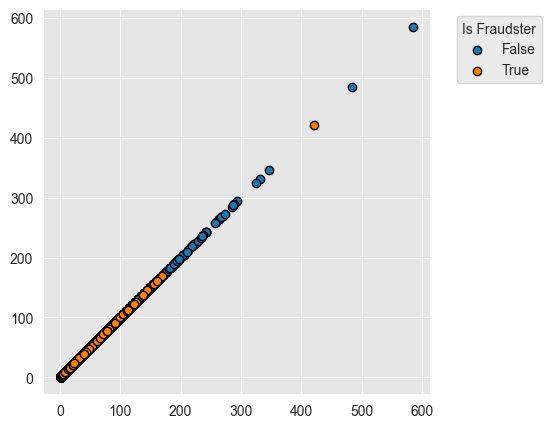

In [15]:
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))

groups = df_final.groupby('is_fraudster')
for name, group in groups:
    ax.scatter(group.max_tx_30d, group.max_tx_30d, edgecolors='k', label=name, alpha=1, marker='o')
ax.legend(loc='upper left', bbox_to_anchor=(1.05,1), title = 'Is Fraudster')

Is Fraudster: [0 1]
int64


[Text(0, 0, '6889'), Text(0, 0, '297')]

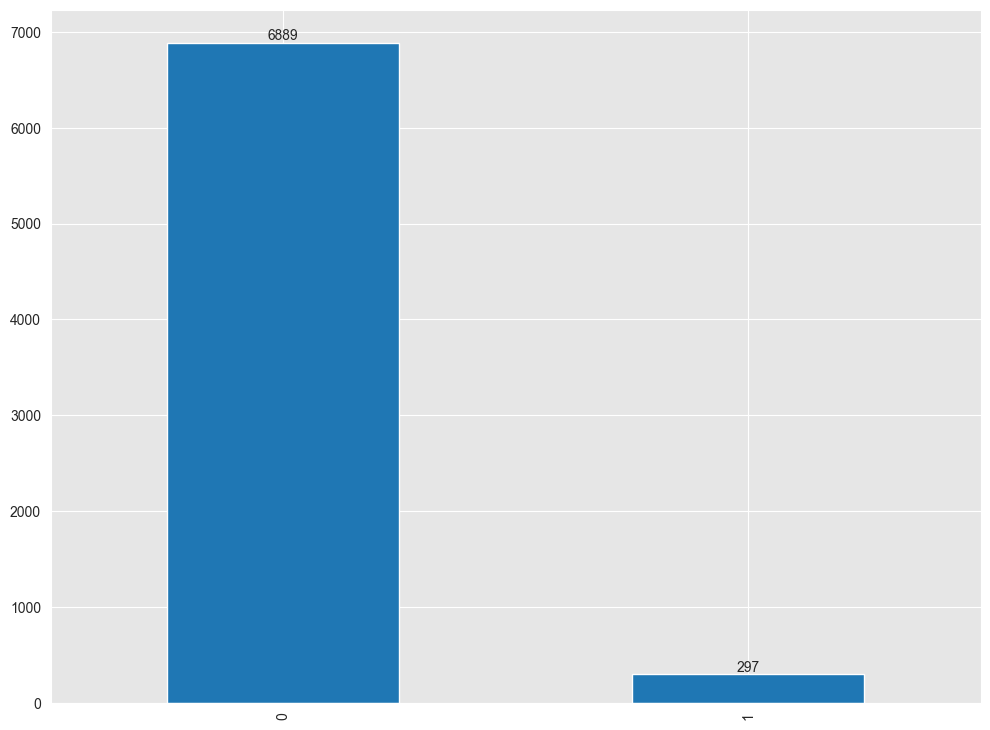

In [16]:
# Change the is_fraudster column dtype from bool to integer i.e., 0 and 1
df_final['is_fraudster'] = df_final['is_fraudster'].replace([False, True], [0,1])

# Visualize the target variable
print(f'Is Fraudster: {df_final.is_fraudster.unique()}')
print(df_final['is_fraudster'].dtype)

ax = df_final['is_fraudster'].value_counts().plot(kind='bar', figsize=(12, 9))
ax.bar_label(ax.containers[0])


KYC: [1 0]
int64


[Text(0, 0, '6296'), Text(0, 0, '890')]

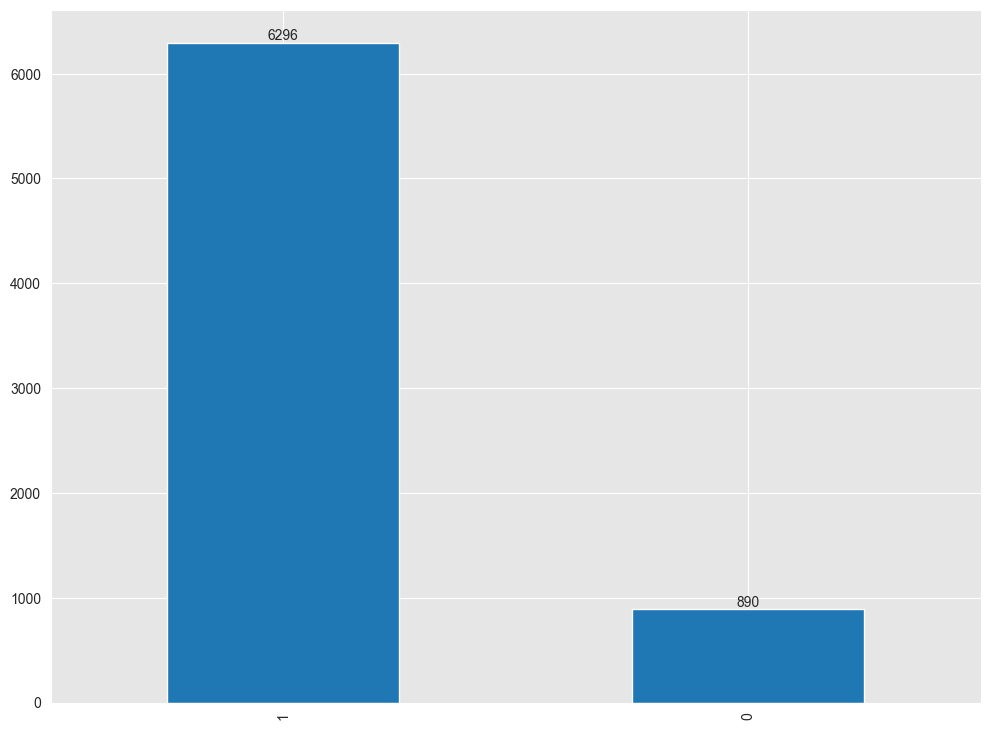

In [17]:
# Replace all values of KYC column. Replace PASSED with 1, everything else to be 0
df_final['kyc'] = np.where(df_final['kyc'].isin(['NONE', 'FAILED', 'PENDING']), 0, 1)

# Visualize the KYC variable
print(f'KYC: {df_final.kyc.unique()}')
print(df_final['kyc'].dtype)

ax = df_final['kyc'].value_counts().plot(kind='bar', figsize=(12, 9))
ax.bar_label(ax.containers[0])

In [18]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
has_email,7186.0,0.964097,0.186062,0.0,1.000,1.00,1.000000,1.0
is_fraudster,7186.0,0.041330,0.199067,0.0,0.000,0.00,0.000000,1.0
birth_year,7186.0,1983.388951,11.387634,1927.0,1978.000,1986.00,1992.000000,2000.0
kyc,7186.0,0.876148,0.329435,0.0,1.000,1.00,1.000000,1.0
failed_sign_in_attempts,7186.0,0.009880,0.144632,0.0,0.000,0.00,0.000000,6.0
num_tx_weekend,7186.0,23.919148,46.427258,0.0,1.000,7.00,25.000000,684.0
num_tx_night,7186.0,10.478848,25.302120,0.0,0.000,2.00,9.000000,636.0
max_tx_1d,7186.0,7.351934,5.982309,1.0,3.000,6.00,10.000000,95.0
max_amt_1d,7186.0,62238.908708,296612.273809,0.0,2535.500,15246.00,42712.000000,10000000.0
max_tx_7d,7186.0,16.259672,16.286849,1.0,4.000,11.00,24.000000,238.0


## Let us check for collinearity in the features

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/3211041764.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_final.corr()


<Axes: >

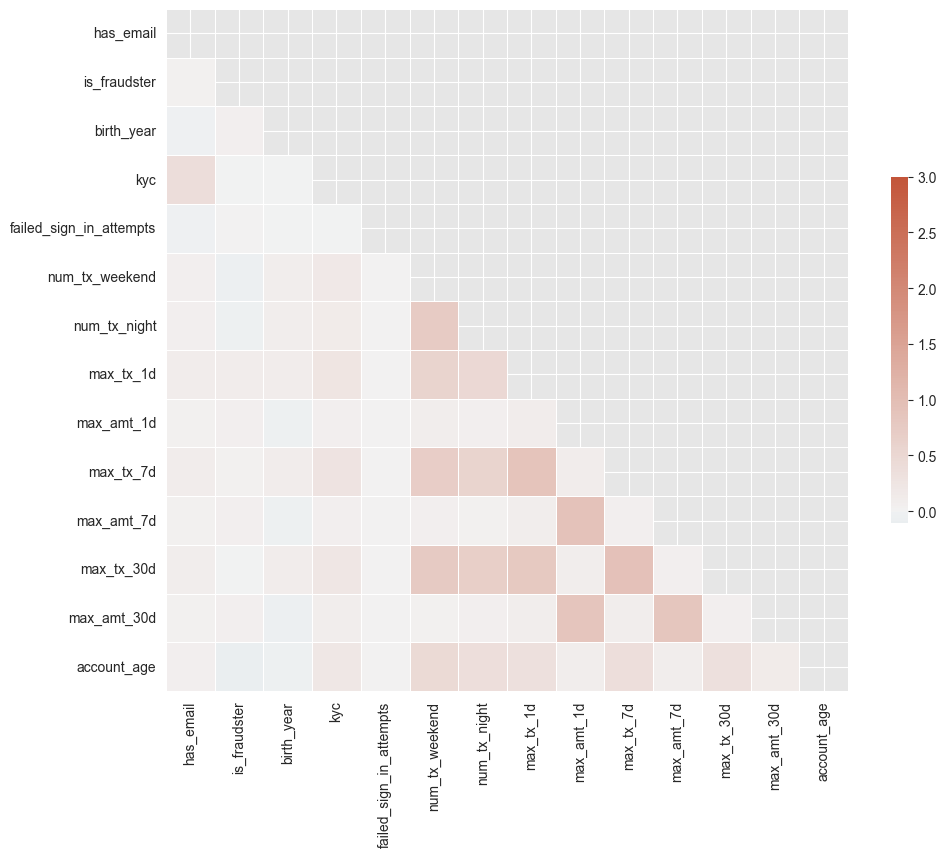

In [29]:
# Generate a mask for the upper triangle
corr = df_final.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230,20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

In [37]:
df_numerical = df_final[['has_email', 'kyc', 'num_tx_night', 'max_tx_1d', 'max_amt_1d', 'account_age']]

# Printing the top k correlations

In [33]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [38]:
print('Top Absolute Correlations')
print(get_top_abs_correlations(df_numerical, 10))

Top Absolute Correlations
num_tx_night  max_tx_1d       0.496761
has_email     kyc             0.377029
num_tx_night  account_age     0.356550
max_tx_1d     account_age     0.333060
kyc           max_tx_1d       0.249308
              account_age     0.213524
              num_tx_night    0.140611
max_tx_1d     max_amt_1d      0.107204
has_email     max_tx_1d       0.106634
max_amt_1d    account_age     0.090724
dtype: float64


## Decision Tree with Cross-Validation
- We will divide the dataset into train and test splits.
- We will perform cross validation on the training dataset and measure:
    - AUC ROC, Average Precision and Balanced Accuracy
- We will do this for baseline (class weights of 1 for each class) and cost-sensitive (class weight = Imbalance ratio for class 0 because they're higher in number)

In [39]:
# Creating the train test split

X_train, X_test, y_train, y_test = train_test_split(df_final[df_numerical.columns.tolist()],
                                                    df_final['is_fraudster'], test_size=0.25, random_state=42)

print(f'Size of training data is {X_train.shape} and size of the test data is {X_test.shape}')

Size of training data is (5389, 6) and size of the test data is (1797, 6)


In [40]:
# Create a function to do cross validation and return results

def kfold_cv_with_classifier(classifier, X, y, n_splits=5, strategy_name='Baseline Classifier'):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results_ = cross_validate(classifier, X, y, cv=cv,
                                 scoring=['roc_auc', 'average_precision', 'balanced_accuracy'], return_estimator=True)
    
    results = round(pd.DataFrame(cv_results_), 3)
    results_mean = list(results.mean().values)
    results_std = list(results.std().values)
    results_df = pd.DataFrame([[str(round(results_mean[i], 3)) + '+/-' + str(round(results_std[i], 3)) for i in range(len(results))]],
                              columns = ['Fit time (s)', 'Score time (s)', 'AUC ROC', 'Average Precision', 'Balanced Accuracy'])
    results_df.rename(index={0:strategy_name}, inplace=True)

    return results_df

In [41]:
tree = DecisionTreeClassifier(max_depth=5, class_weight={0:1,1:1}, random_state=42)

results_df_dt_baseline = kfold_cv_with_classifier(tree, X_train, y_train, n_splits=5, strategy_name='Decision Tree - Baseline')

results_df_dt_baseline

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Decision Tree - Baseline,0.005+/-0.001,0.002+/-0.0,0.773+/-0.024,0.272+/-0.083,0.597+/-0.054


- The performances are rather good as the AUC ROC is > 0.5 and Average Precision is > 0.05. The balanced accuracy is however not so high.
- Let us try to improve it by assigning class weights.
- We know from the above result of the .describe() function on df_final that the mean of is_fraudster column = 0.041330
- We will set that as the Imbalance Ratio (IR) = 0.041330

In [42]:
IR = 0.041330
class_weight = {0:IR,1:1}

In [43]:
tree_cc = DecisionTreeClassifier(max_depth=5,class_weight=class_weight, random_state=42)

results_df_dt_cost_sensitive = kfold_cv_with_classifier(tree_cc, X_train, y_train, n_splits=5, strategy_name='Decision Tree - Cost-sensitive')

pd.concat([results_df_dt_baseline, results_df_dt_cost_sensitive])

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Decision Tree - Baseline,0.005+/-0.001,0.002+/-0.0,0.773+/-0.024,0.272+/-0.083,0.597+/-0.054
Decision Tree - Cost-sensitive,0.005+/-0.0,0.002+/-0.0,0.783+/-0.015,0.253+/-0.048,0.72+/-0.02


## Logistic Regression with Cross-Validation
- Let us repeat the process for a Logistic Regression classifer (2 models: baseline, cost-sensitive)
- Final comparison of the result for all 4 models is shown

In [44]:
logistic = LogisticRegression(C=1, class_weight={0:1,1:1}, random_state=42)
results_df_lr_baseline = kfold_cv_with_classifier(logistic, X_train, y_train, n_splits=5, strategy_name='Logistic Regression - Baseline')

pd.concat([results_df_dt_baseline, results_df_dt_cost_sensitive, results_df_lr_baseline])

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Decision Tree - Baseline,0.005+/-0.001,0.002+/-0.0,0.773+/-0.024,0.272+/-0.083,0.597+/-0.054
Decision Tree - Cost-sensitive,0.005+/-0.0,0.002+/-0.0,0.783+/-0.015,0.253+/-0.048,0.72+/-0.02
Logistic Regression - Baseline,0.059+/-0.043,0.002+/-0.0,0.639+/-0.046,0.054+/-0.007,0.5+/-0.0


- The logistic regression baseline performs worse than the decision tree
- Let us adjust the class weights

In [45]:
logistic_cc = LogisticRegression(C=1, class_weight=class_weight, random_state=42)
results_df_lr_cost_sensitive = kfold_cv_with_classifier(logistic_cc, X_train, y_train, n_splits=5, strategy_name='Logistic Regression - Cost-Sensitive')

pd.concat([results_df_dt_baseline, results_df_dt_cost_sensitive, results_df_lr_baseline, results_df_lr_cost_sensitive])

/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_mean = list(results.mean().values)
/var/folders/wg/8yz1tny10yl9ct8bq7zl3pp00000gn/T/ipykernel_20873/550837358.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced Accuracy
Decision Tree - Baseline,0.005+/-0.001,0.002+/-0.0,0.773+/-0.024,0.272+/-0.083,0.597+/-0.054
Decision Tree - Cost-sensitive,0.005+/-0.0,0.002+/-0.0,0.783+/-0.015,0.253+/-0.048,0.72+/-0.02
Logistic Regression - Baseline,0.059+/-0.043,0.002+/-0.0,0.639+/-0.046,0.054+/-0.007,0.5+/-0.0
Logistic Regression - Cost-Sensitive,0.023+/-0.013,0.002+/-0.0,0.795+/-0.034,0.19+/-0.046,0.696+/-0.029


- It looks like the cost-sensitive version of the Logistic Regression classifier is performing the best out of all.
- Let us fit our training data to it and carry out predictions on test data.

# Before feature selection

![Alt text](image.png)